In [ ]:
# This notebook trains & benchmarks flows on a multivariate gaussian problem.
# See flows.py for a library of modules.

In [1]:
# This cell initializes a multivariate normal problem, with large means and covariance
import torch
from torch.distributions import *
from flows import *

# - See kl-estimator.ipynb for details & benchmark
def kl_estimate_log(log_px, log_qx, n):
    return (log_px - log_qx).mean()

# dataset is skewed, correlated multivariate gaussian
dim = 2
datapoints = 2500

mu = torch.tensor([4.5, -4.5])
sigma = torch.tensor([[3.0, 2], [2, 3.0]])
dist = MultivariateNormal(mu, sigma)

table = dist.sample_n(datapoints)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)
print(table)

tensor([[ 7.2520, -1.6382],
        [ 6.0178, -0.8700],
        [ 2.0968, -7.9473],
        ...,
        [ 2.8890, -4.4902],
        [ 4.3554, -5.0276],
        [ 2.0939, -6.0583]])


In [2]:
# This cell introduces a multivariate gaussian mixture problem, where the means and covariance of each gaussian are taken from the uniform distribution
dim = 2
m = 4
datapoints = 2500

from torch.distributions import MixtureSameFamily

means = torch.zeros(m,2).normal_(mean=0.0, std=1.0)
stddevs = torch.zeros(m,2).log_normal_(mean=-0.8, std=0.1)

mix = Categorical(torch.ones(m,))
comp = Independent(Normal(means, stddevs), 1)
dist = MixtureSameFamily(mix, comp)

table = dist.sample_n(datapoints)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

In [65]:
# flows convert to normal dist
normal_flows = Flows(
    ScaleBiasFlow(dim),
    SoftexpFlow(dim),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 2),

    ScaleBiasFlow(dim),    
    SoftlogFlow(),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 2),

    ScaleBiasFlow(dim),    
    SoftexpFlow(dim),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 2),

    ScaleBiasFlow(dim),    
    SoftlogFlow(),
    ScaleBiasFlow(dim),    
    HouseholderQrConvolution(dim, 2),
    
    ScaleBiasFlow(dim),    
)

# final flow converts to normal

# train on NLL
net = FlowModule(normal_flows, NegLogLikelihoodLoss(dim))

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [68]:
final_loss = 0.0
for batch in range(100):  #1oop over the dataset multiple times
    for _, data in enumerate(dataloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net(data[0])
        loss.backward()
        optimizer.step()
        final_loss = loss
print("final loss: %.03f" % final_loss)

final loss: 2.312


In [78]:
# Estimate the KL divergence between the source distribution, and the transformed data (under the change of variables, so we add log_det)
n = 50000
points = dist.sample_n(n)
p_points = dist.log_prob(points)

normalized_points, log_det = normal_flows(points)
dist_target = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
p_normalized_points = dist_target.log_prob(normalized_points) + log_det

uniform_with_y = torch.stack([p_points.exp(), p_normalized_points.exp()], dim=1)
print(uniform_with_y)

print()

print("~kl div:", kl_estimate_log(p_points, p_normalized_points, n))

tensor([[0.1576, 0.1602],
        [0.0746, 0.0792],
        [0.0959, 0.1063],
        ...,
        [0.0329, 0.0281],
        [0.0928, 0.1017],
        [0.0500, 0.0440]], grad_fn=<StackBackward>)

~kl div: tensor(0.0374, grad_fn=<MeanBackward0>)


In [70]:
# Run the KL divergence estimate at each layer in the network
n = 5000
points = dist.sample_n(n)
p_points = dist.log_prob(points)

for ps, log_det, f in zip(*normal_flows.forward_trace(points),normal_flows.flows):
    dist_target = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
    p_normalized_points = dist_target.log_prob(ps) + log_det
    approx_kl_divergence = kl_estimate_log(p_points, p_normalized_points, n).item()
    params = list(f.parameters())
    print("%1.4f - %s:" % (approx_kl_divergence, f))

1.3390 - ScaleBiasFlow():
64.6520 - SoftexpFlow():
36.1287 - ScaleBiasFlow():
20.9378 - HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
):
19.4627 - ScaleBiasFlow():
0.8511 - SoftlogFlow():
1.2409 - ScaleBiasFlow():
1.9298 - HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
):
4.2424 - ScaleBiasFlow():
2417.1890 - SoftexpFlow():
968.2440 - ScaleBiasFlow():
594.7492 - HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
):
74.6776 - ScaleBiasFlow():
0.4339 - SoftlogFlow():
0.2895 - ScaleBiasFlow():
0.1548 - HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
):
0.0359 - ScaleBiasFlow():


In [71]:
for f in normal_flows.flows:
    print(f)
    for name, param in f.named_parameters():
        print("  %s = %s" % (name, param.data))
    print()

ScaleBiasFlow()
  s = tensor([1.2974, 0.9272])
  b = tensor([-0.3849, -0.3007])

SoftexpFlow()
  a = tensor([3.0382, 2.6665])

ScaleBiasFlow()
  s = tensor([0.7415, 1.0761])
  b = tensor([0.3074, 0.0289])

HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
)
  r = tensor([[0.7603, 0.1567],
        [0.0000, 1.0399]])
  vs.0.v = tensor([[-1.5555],
        [ 0.0236]])
  vs.1.v = tensor([[-0.7450],
        [ 0.0054]])

ScaleBiasFlow()
  s = tensor([1.0264, 0.8014])
  b = tensor([ 0.3543, -0.1504])

SoftlogFlow()

ScaleBiasFlow()
  s = tensor([1.1931, 1.1802])
  b = tensor([-0.1323, -0.8498])

HouseholderQrConvolution(
  (vs): ModuleList(
    (0): HouseholderReflectionFlow()
    (1): HouseholderReflectionFlow()
  )
)
  r = tensor([[1.1907, 0.0773],
        [0.0000, 1.3650]])
  vs.0.v = tensor([[-0.9595],
        [-1.5897]])
  vs.1.v = tensor([[-0.5272],
        [ 1.2642]])

ScaleBiasFlow()
  s = tensor([1.3968, 1.1771]

In [76]:
import numpy
import seaborn
import matplotlib.pylab
import pandas

def jointplot_2d(data, title=""):
    xs = pandas.DataFrame(data[0:3000, 0:1].detach().numpy(), columns = ['X'])
    ys = pandas.DataFrame(data[0:3000, 1:2].detach().numpy(), columns = ['Y'])

    # xlim = (xs.quantile(q=quantile, axis=0).iloc[0], xs.quantile(q=1 - quantile, axis=0).iloc[0])
    # ylim = (ys.quantile(q=quantile, axis=0).iloc[0], ys.quantile(q=1 - quantile, axis=0).iloc[0])
    # lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    # xlim=lim, ylim=lim, 
    seaborn.jointplot(xs, ys, kind="hex", color="#4CB391").set_axis_labels(title, "")

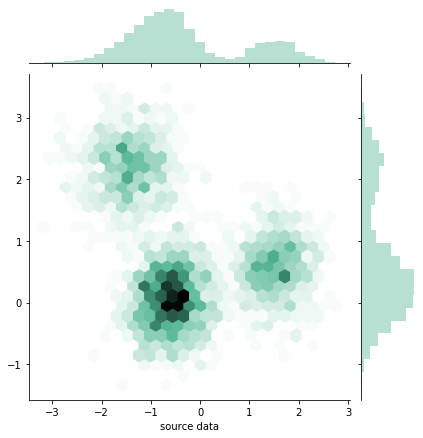

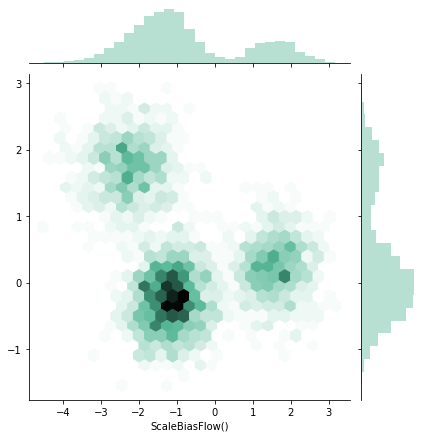

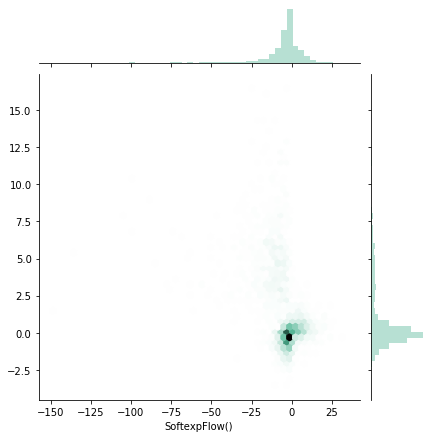

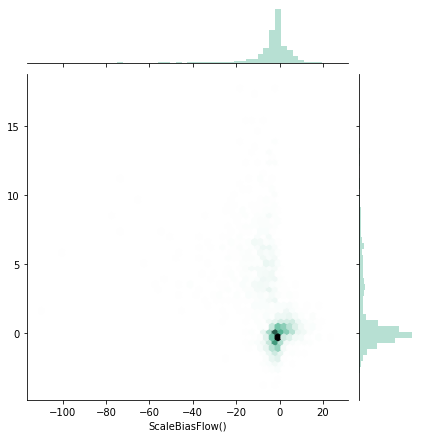

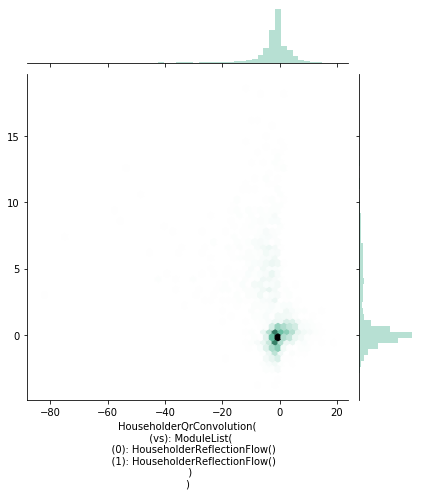

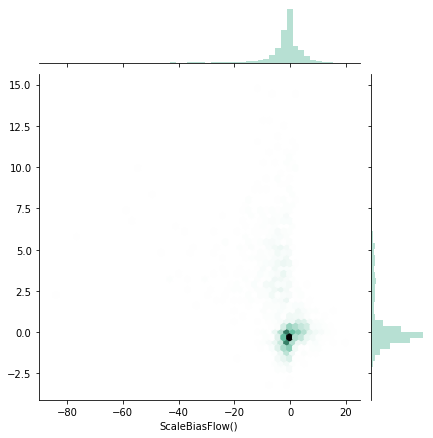

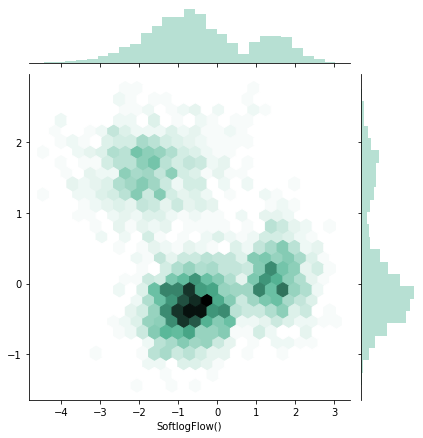

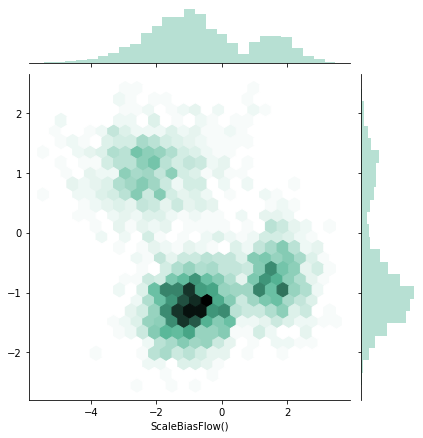

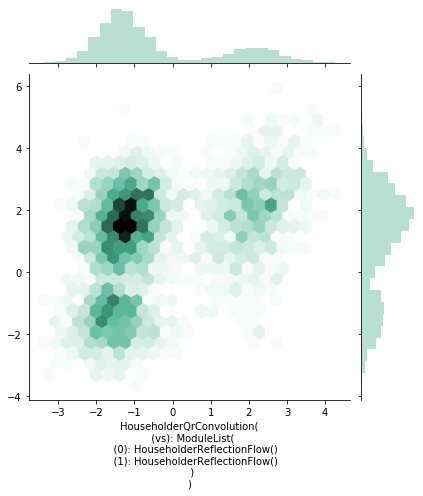

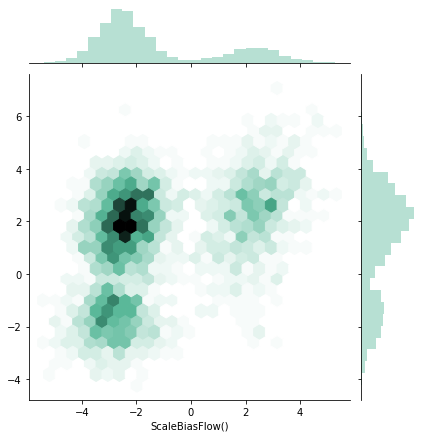

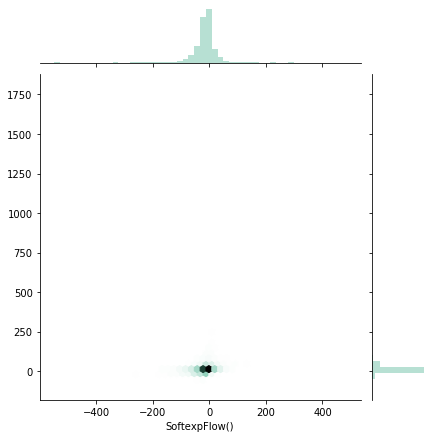

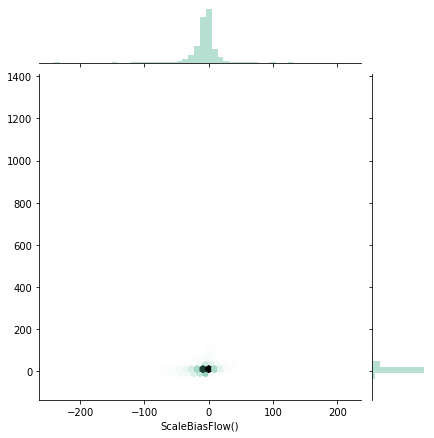

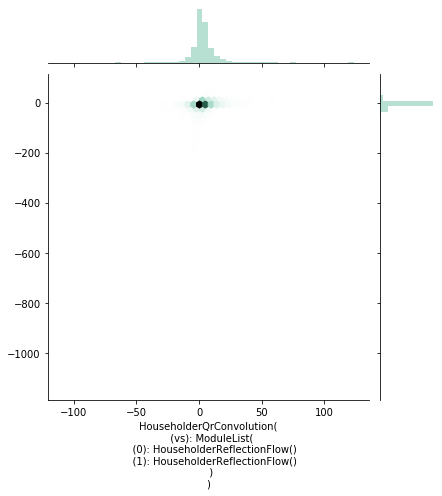

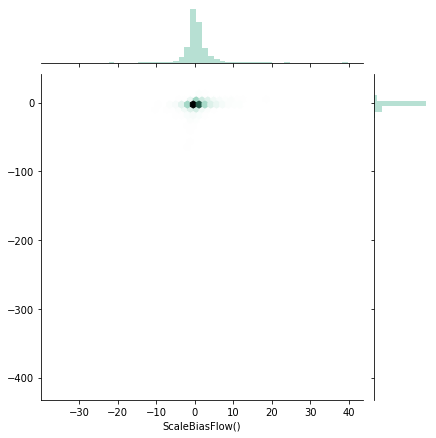

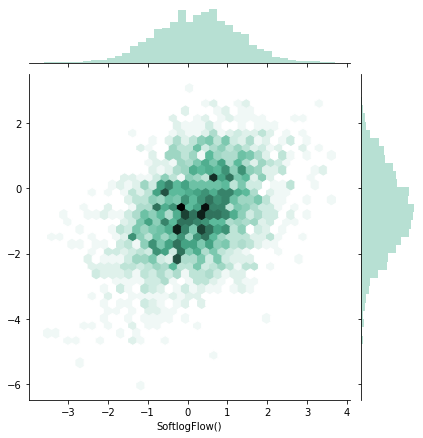

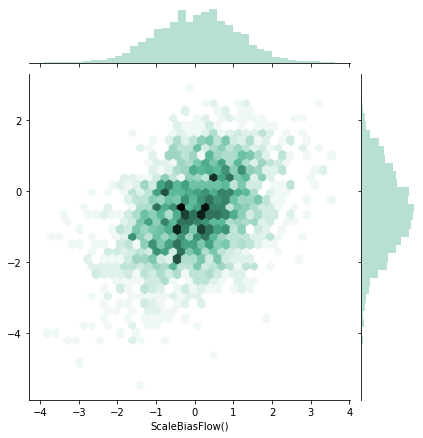

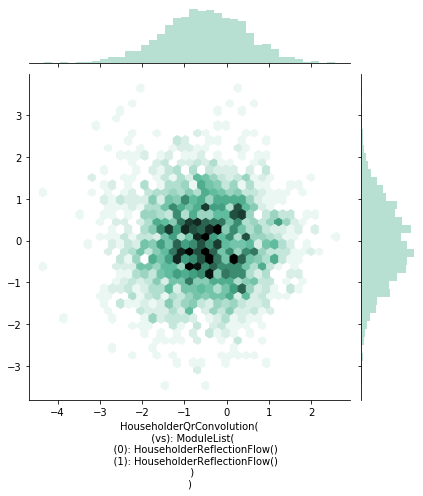

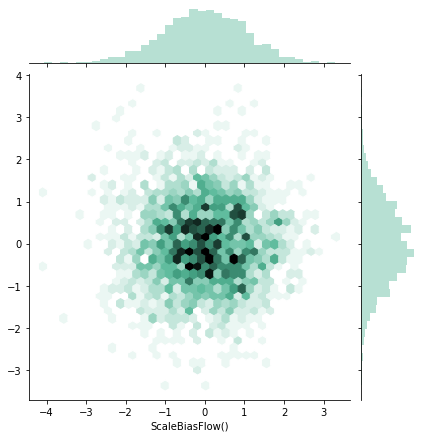

In [77]:
# A series of trace plots from the gaussian mixture problem
jointplot_2d(table, title="source data")
for ps, log_dest, f in zip(*normal_flows.forward_trace(table),normal_flows.flows):
    jointplot_2d(ps, title=str(f))